# PSyKE's demo for regression tasks

Some imports.

In [12]:
from psyke import Extractor
from psyke.tuning.pedro import PEDRO
from psyke.tuning import Objective
from psyke.tuning.crash import CRASH
from sklearn.tree import DecisionTreeRegressor
from psyke.utils.logic import pretty_theory
from psyke.utils.metrics import mae, mse, r2
from sklearn.model_selection import train_test_split
from psyke.utils import Target
from matplotlib import pyplot as plt
import pandas as pd

Import a dataset.

In [13]:
#dataset = pd.read_csv("datasets/df.csv")
#dataset = dataset[["X", "Y", "Z4"]].dropna()
dataset = pd.read_csv("datasets/CCPP.csv", sep=";", decimal=",")
#dataset

Split between train and test set in a reproducible way.

In [14]:
train, test = train_test_split(dataset, test_size=0.5, random_state=10)

We use as predictor a KNN and we train it.

In [15]:
#predictor = KNeighborsRegressor(n_neighbors=3).fit(train.iloc[:, :-1], train.iloc[:, -1])
predictor = DecisionTreeRegressor().fit(train.iloc[:, :-1], train.iloc[:, -1])
#predictor = LinearRegression().fit(train.iloc[:, :-1], train.iloc[:, -1])

predicted = predictor.predict(test.iloc[:, :-1]).flatten()
true = test.iloc[:, -1]

print(f'MAE = {mae(true, predicted):.2f}')
print(f'MSE = {mse(true, predicted):.2f}')
print(f'R2 = {r2(true, predicted):.2f}')

MAE = 3.41
MSE = 25.13
R2 = 0.91


We define a function to print the extractors' evaluation

In [17]:
def evaluate(name, extractor, true, predicted):
    extracted = extractor.predict(test.iloc[:, :-1])
    print(f'{name} performance ({extractor.n_rules} rules):\n'
          f'MAE = {mae(true, extracted):.2f}\nMAE fidelity = {mae(predicted, extracted):.2f}\n'
          f'R2 = {r2(true, extracted):.2f}\nR2 fidelity = {r2(predicted, extracted):.2f}\n')

We create several extractors that use ITER, GridEx and GridREx algorithms to extract prolog rules from the predictor.

In [18]:
creepy = Extractor.creepy(predictor, depth=3, error_threshold=0.02, output=Target.REGRESSION)
theory_from_creepy = creepy.extract(train)
evaluate('CReEPy', creepy, true, predicted)
print('CReEPy extracted rules:\n\n' + pretty_theory(theory_from_creepy))

CReEPy performance (4 rules):
MAE = 3.37
MAE fidelity = 3.51
R2 = 0.94
R2 fidelity = 0.93

CReEPy extracted rules:

'PE'(AP, AT, RH, V, PE) :-
    AT in [6.21, 32.45], V in [35.39, 50.16], AP in [998.07, 1026.40], RH in [35.63, 100.10], PE is 499.89 + -2.16 * AP + -0.27 * AT + 0.01 * RH + -0.11 * V.
'PE'(AP, AT, RH, V, PE) :-
    AT in [6.21, 32.45], V in [34.02, 50.16], AP in [997.90, 1026.41], RH in [35.63, 100.10], PE is 697.90 + -1.74 * AP + -2.04 * AT + -0.17 * RH + 0.61 * V.
'PE'(AP, AT, RH, V, PE) :-
    AT in [6.21, 35.77], V in [25.35, 81.56], AP in [997.84, 1026.45], RH in [25.55, 100.12], PE is 234.73 + -1.42 * AP + -0.29 * AT + 0.26 * RH + -0.12 * V.
'PE'(AP, AT, RH, V, PE).


In [19]:
orchid = Extractor.orchid(predictor, depth=2, error_threshold=0.02, output=Target.REGRESSION)
theory_from_orchid = orchid.extract(train)
evaluate('ORCHiD', orchid, true, predicted)
print('ORCHiD extracted rules:\n\n' + pretty_theory(theory_from_orchid))

ORCHiD performance (4 rules):
MAE = 3.37
MAE fidelity = 3.51
R2 = 0.94
R2 fidelity = 0.93

ORCHiD extracted rules:

'PE'(AP, AT, RH, V, PE) :-
    AT in [6.21, 32.45], V in [34.02, 50.16], AP in [997.90, 1026.41], RH in [35.63, 100.10], PE is 502.53 + -2.16 * AP + -0.26 * AT + 0.01 * RH + -0.11 * V.
'PE'(AP, AT, RH, V, PE) :-
    AT in [6.21, 35.77], V in [25.35, 81.56], AP in [997.84, 1026.45], RH in [25.55, 100.12], PE is 234.73 + -1.42 * AP + -0.29 * AT + 0.26 * RH + -0.12 * V.
'PE'(AP, AT, RH, V, PE) :-
    AT in [3.30, 14.60], V in [34.68, 44.47], AP in [1011.31, 1033.25], RH in [58.98, 98.68], PE is 720.26 + -2.20 * AP + -0.47 * AT + -0.18 * RH + -0.22 * V.
'PE'(AP, AT, RH, V, PE).


In [21]:
crash = CRASH(predictor, train, max_depth=3, patience=1, readability_tradeoff=.5,
              algorithm=CRASH.Algorithm.CReEPy, output=Target.REGRESSION)
crash.search()
(_, _, depth, threshold) = crash.get_best()[0]

creepy = Extractor.creepy(predictor, depth=depth, error_threshold=threshold, output=Target.REGRESSION)
theory_from_creepy = creepy.extract(train)
evaluate('CReEPy', creepy, true, predicted)
print('CReEPy extracted rules:\n\n' + pretty_theory(theory_from_creepy))

Algorithm.CReEPy. Depth: 1. Threshold = 0.00. MAE = 3.54, 2 rules
Algorithm.CReEPy. Depth: 1. Threshold = 0.00. MAE = 3.56, 2 rules

Algorithm.CReEPy. Depth: 2. Threshold = 0.00. MAE = 3.45, 3 rules
Algorithm.CReEPy. Depth: 2. Threshold = 0.00. MAE = 3.53, 3 rules

Algorithm.CReEPy. Depth: 3. Threshold = 0.00. MAE = 3.56, 4 rules
Algorithm.CReEPy. Depth: 3. Threshold = 0.00. MAE = 3.51, 4 rules
Algorithm.CReEPy. Depth: 3. Threshold = 0.00. MAE = 3.52, 4 rules

**********************
Best Algorithm.CReEPy
**********************
MAE = 3.45, 3 rules
Threshold = 0.00
Depth = 2

**********************
Best   MAE  
**********************
MAE = 3.45, 3 rules
Threshold = 0.00
Depth = 2

**********************
Best N rules
**********************
MAE = 3.56, 2 rules
Threshold = 0.00
Depth = 1

CReEPy performance (3 rules):
MAE = 3.37
MAE fidelity = 3.50
R2 = 0.94
R2 fidelity = 0.93

CReEPy extracted rules:

'PE'(AP, AT, RH, V, PE) :-
    AT in [6.21, 32.45], V in [34.02, 50.16], AP in [997.90, 1

In [22]:
crash = CRASH(predictor, train, max_depth=3, patience=1, readability_tradeoff=.75, algorithm=CRASH.Algorithm.ORCHiD)
crash.search()
(_, _, depth, threshold) = crash.get_best()[0]

orchid = Extractor.orchid(predictor, depth=depth, error_threshold=threshold, output=Target.REGRESSION)
theory_from_orchid = orchid.extract(train)
evaluate('ORCHiD', orchid, true, predicted)
print('ORCHiD extracted rules:\n\n' + pretty_theory(theory_from_orchid))

Algorithm.ORCHiD. Depth: 1. Threshold = 0.00. MAE = 8.46, 2 rules
Algorithm.ORCHiD. Depth: 1. Threshold = 0.00. MAE = 8.46, 2 rules

Algorithm.ORCHiD. Depth: 2. Threshold = 0.00. MAE = 7.59, 4 rules
Algorithm.ORCHiD. Depth: 2. Threshold = 0.00. MAE = 7.56, 4 rules
Algorithm.ORCHiD. Depth: 2. Threshold = 0.00. MAE = 6.67, 4 rules
Algorithm.ORCHiD. Depth: 2. Threshold = 0.00. MAE = 7.58, 4 rules

Algorithm.ORCHiD. Depth: 3. Threshold = 0.00. MAE = 5.85, 8 rules
Algorithm.ORCHiD. Depth: 3. Threshold = 0.00. MAE = 5.65, 8 rules
Algorithm.ORCHiD. Depth: 3. Threshold = 0.00. MAE = 6.01, 8 rules

**********************
Best Algorithm.ORCHiD
**********************
MAE = 6.67, 4 rules
Threshold = 0.00
Depth = 2

**********************
Best   MAE  
**********************
MAE = 5.65, 8 rules
Threshold = 0.00
Depth = 3

**********************
Best N rules
**********************
MAE = 8.46, 2 rules
Threshold = 0.00
Depth = 1

ORCHiD performance (4 rules):
MAE = 3.37
MAE fidelity = 3.51
R2 = 0.94
R2

In [23]:
it = Extractor.iter(predictor, min_update=1.0 / 10, n_points=1, max_iterations=600,
                    min_examples=100, threshold=5)
theory_from_iter = it.extract(train)
evaluate('ITER', it, true, predicted)
print('ITER extracted rules:\n\n' + pretty_theory(theory_from_iter))

ITER performance (15 rules):
MAE = 4.26
MAE fidelity = 4.37
R2 = 0.90
R2 fidelity = 0.89

ITER extracted rules:

'PE'(AP, AT, RH, V, 430.92) :-
    AT in [29.21, 35.77], V in [62.52, 81.56], AP in [992.88, 1033.25], RH in [25.55, 100.15].
'PE'(AP, AT, RH, V, 435.94) :-
    AT in [22.53, 29.21], V in [62.52, 81.56], AP in [992.88, 1033.25], RH in [25.55, 100.15].
'PE'(AP, AT, RH, V, 441.46) :-
    AT in [29.21, 35.77], V in [25.35, 62.52], AP in [992.88, 1033.25], RH in [25.55, 100.15].
'PE'(AP, AT, RH, V, 446.76) :-
    AT in [15.84, 22.53], V in [62.52, 81.56], AP in [992.88, 1033.25], RH in [25.55, 100.15].
'PE'(AP, AT, RH, V, 462.74) :-
    AT in [12.50, 15.84], V in [62.52, 81.56], AP in [992.88, 1033.25], RH in [25.55, 100.15].
'PE'(AP, AT, RH, V, 470.29) :-
    AT in [9.15, 12.50], V in [62.52, 81.56], AP in [992.88, 1033.25], RH in [25.55, 100.15].
'PE'(AP, AT, RH, V, 478.07) :-
    AT in [5.81, 9.15], V in [62.52, 81.56], AP in [992.88, 1033.25], RH in [25.55, 100.15].
'PE'(AP,

In [24]:
pedro = PEDRO(predictor, train, max_mae_increase=1.2, min_rule_decrease=0.9, readability_tradeoff=0.1,
              max_depth=1, patience=1, algorithm=PEDRO.Algorithm.GRIDEX, objective=Objective.MODEL)
pedro.search()
(_, _, threshold, grid) = pedro.get_best()[0]

gridEx = Extractor.gridex(predictor, grid, threshold=threshold)
theory_from_gridEx = gridEx.extract(train)
evaluate('GridEx', gridEx, true, predicted)
print('GridEx extracted rules:\n\n' + pretty_theory(theory_from_gridEx))

Algorithm.GRIDEX. Grid (1). Fixed (2). Threshold = 0.00. MAE = 6.47, 15 rules
Algorithm.GRIDEX. Grid (1). Fixed (2). Threshold = 0.00. MAE = 6.47, 15 rules

Algorithm.GRIDEX. Grid (1). Fixed (3). Threshold = 0.00. MAE = 5.12, 56 rules
Algorithm.GRIDEX. Grid (1). Fixed (3). Threshold = 0.00. MAE = 5.12, 56 rules

Algorithm.GRIDEX. Grid (1). Adaptive ([(0.99, 2)]). Threshold = 0.00. MAE = 7.37, 2 rules
Algorithm.GRIDEX. Grid (1). Adaptive ([(0.99, 2)]). Threshold = 0.00. MAE = 7.37, 2 rules

Algorithm.GRIDEX. Grid (1). Adaptive ([(0.3, 2)]). Threshold = 0.00. MAE = 6.80, 4 rules
Algorithm.GRIDEX. Grid (1). Adaptive ([(0.3, 2)]). Threshold = 0.00. MAE = 6.80, 4 rules

Algorithm.GRIDEX. Grid (1). Adaptive ([(0.99, 3)]). Threshold = 0.00. MAE = 6.62, 3 rules
Algorithm.GRIDEX. Grid (1). Adaptive ([(0.99, 3)]). Threshold = 0.00. MAE = 6.62, 3 rules

Algorithm.GRIDEX. Grid (1). Adaptive ([(0.3, 3)]). Threshold = 0.00. MAE = 5.13, 9 rules
Algorithm.GRIDEX. Grid (1). Adaptive ([(0.3, 3)]). Thres

In [25]:
#pedro = PEDRO(predictor, train, max_mae_increase=1.2, min_rule_decrease=0.9, readability_tradeoff=0.1,
#              max_depth=2, patience=1, algorithm=PEDRO.Algorithm.GRIDREX, objective=Objective.MODEL)
#pedro.search()
(_, _, threshold, grid) = pedro.get_best()[0]

gridREx = Extractor.gridrex(predictor, grid, threshold=threshold)
theory_from_gridREx = gridREx.extract(train)
evaluate('GridREx', gridREx, true, predicted)
print('GridREx extracted rules:\n\n' + pretty_theory(theory_from_gridREx))

**********************
Best Algorithm.GRIDEX
**********************
MAE = 5.03, 5 rules
Threshold = 0.00
Iterations = 1
Strategy = Adaptive ([(0.99, 5)])

**********************
Best   MAE  
**********************
MAE = 4.29, 10 rules
Threshold = 0.00
Iterations = 1
Strategy = Adaptive ([(0.99, 10)])

**********************
Best N rules
**********************
MAE = 7.37, 2 rules
Threshold = 0.00
Iterations = 1
Strategy = Adaptive ([(0.99, 2)])

GridREx performance (5 rules):
MAE = 3.24
MAE fidelity = 3.44
R2 = 0.94
R2 fidelity = 0.93

GridREx extracted rules:

'PE'(AP, AT, RH, V, PE) :-
    AT in [2.33, 9.02], PE is 589.17 + -1.73 * AP + -0.13 * AT + -0.07 * RH + -0.12 * V.
'PE'(AP, AT, RH, V, PE) :-
    AT in [9.02, 15.71], PE is 581.61 + -2.33 * AP + -0.23 * AT + -0.06 * RH + -0.07 * V.
'PE'(AP, AT, RH, V, PE) :-
    AT in [15.71, 22.39], PE is 341.48 + -1.74 * AP + -0.29 * AT + 0.16 * RH + -0.13 * V.
'PE'(AP, AT, RH, V, PE) :-
    AT in [22.39, 29.08], PE is 124.41 + -1.28 * AP + -0

In [28]:
cart = Extractor.cart(predictor, max_depth=5, max_leaves=6, simplify=True)
theory_from_cart = cart.extract(train)
evaluate('CART', cart, true, predicted)
print('CART extracted rules:\n\n' + pretty_theory(theory_from_cart))

CART performance (6 rules):
MAE = 4.46
MAE fidelity = 4.53
R2 = 0.89
R2 fidelity = 0.88

CART extracted rules:

'PE'(AP, AT, RH, V, 479.15) :-
    AT =< 18.25, AT =< 11.90.
'PE'(AP, AT, RH, V, 435.66) :-
    AT > 18.25, V > 66.20.
'PE'(AP, AT, RH, V, 451.33) :-
    AT > 18.25, V =< 66.20, AT =< 22.89.
'PE'(AP, AT, RH, V, 443.00) :-
    AT > 18.25, V =< 66.20, AT > 22.89.
'PE'(AP, AT, RH, V, 467.45) :-
    AT > 11.90, AT =< 15.64.
'PE'(AP, AT, RH, V, 459.70) :-
    AT > 15.64.


In [150]:
import matplotlib as mpl

size = (4, 3)
cmap = mpl.cm.cool

normalize = mpl.colors.Normalize(vmin=train.PE.min(), vmax=train.PE.max())

def init():
    plt.figure(figsize = size)
    plt.gca().set_xlabel("Ambient temperature (°C)")
    plt.gca().set_ylabel("Exhaust vacuum (cm Hg)")
    plt.xlim(train.AT.min(), train.AT.max())
    plt.ylim(train.V.min(), train.V.max())
    plt.gca().set_rasterized(True)

def plotSamples(X, Y, Z, cm):
    return plt.scatter(X, Y, c = Z, cmap = cm, edgecolor = "k", linewidths = 0.05, s = 7)

def plotCube(X, y1, y2, c, cmap):
    plt.gca().fill_between(X, y1, y2, color = cmap(normalize(c)), edgecolor = None)

def plot(dataset, cmap, name):
    sc = plotSamples(dataset.AT, dataset.V, dataset.PE, cmap)
    plt.colorbar(sc, label = "Net hourly EE output (KW)")
    plt.savefig("regression-{}.pdf".format(name), dpi = 500, bbox_inches = 'tight')
    plt.show()

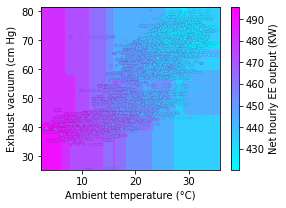

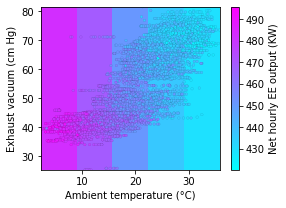

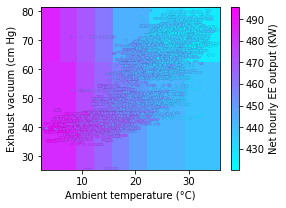

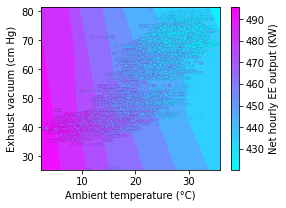

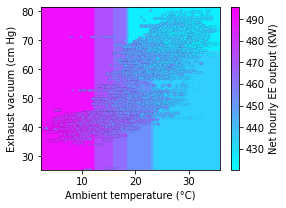

In [151]:
import numpy as np

model = 'dt'

n = 50
m = 3
x = np.linspace(train.AT.min(), train.AT.max(), n)
y = np.linspace(train.V.min(), train.V.max(), n)
w = np.linspace(train.AP.min(), train.AP.max(), m)
z = np.linspace(train.RH.min(), train.RH.max(), m)

xx, yy, ww, zz = np.meshgrid(x, y, w[1], z[1])
grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel(), ww.ravel(), zz.ravel()], columns=dataset.columns[:-1])

init()
plt.gca().tricontourf(grid.AT, grid.V, predictor.predict(grid), cmap=cmap)
plot(dataset, cmap, f'{model}')
plt.show()

init()
for cube in gridEx._hypercubes:
    plotCube(cube['AT'], cube['V'][0], cube['V'][1], cube.output, cmap)
plot(dataset, cmap, f'{model}-gridex')
plt.show()

init()
for cube in it._hypercubes:
    plotCube(cube['AT'], cube['V'][0], cube['V'][1], cube.output, cmap)
plot(dataset, cmap, f'{model}-iter')
plt.show()

pred = gridREx.predict(grid)
idx = [p is not None for p in pred]

init()
plt.gca().tricontourf(grid.AT[idx], grid.V[idx], pred[idx], cmap=cmap)
plot(dataset, cmap, f'{model}-gridrex')
plt.show()

init()
plt.gca().tricontourf(grid.AT, grid.V, cart.predict(grid), cmap=cmap)
plot(dataset, cmap, f'{model}-cart')
plt.show()